In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [ ]:
df = pd.read_csv("all-data.csv", encoding='latin1')

print("Shape:", df.shape)
df.head()

Shape: (4845, 2)


,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
print("Shape:", df.shape)
df.info()

Shape: (4845, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4845 entries, 0 to 4844
Data columns (total 2 columns):
 #   Column                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                           --------------  ----- 
 0   neutral                                                                                                                          4845 non-null   object
 1   According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .  4845 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [ ]:
df.rename(columns={'neutral': 'label'}, inplace=True)
print(df['label'].value_counts())

label
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64


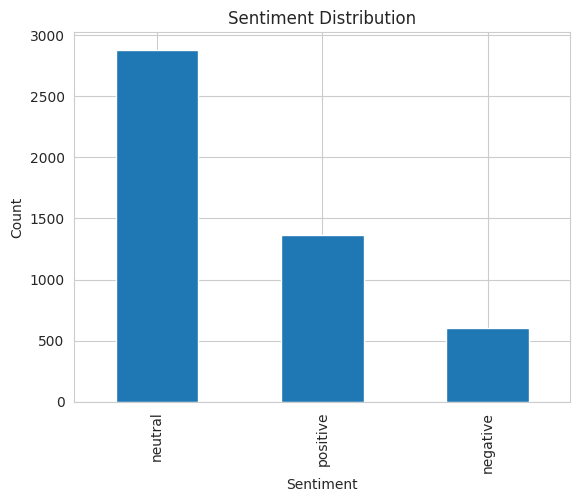

In [ ]:
plt.figure()
df['label'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

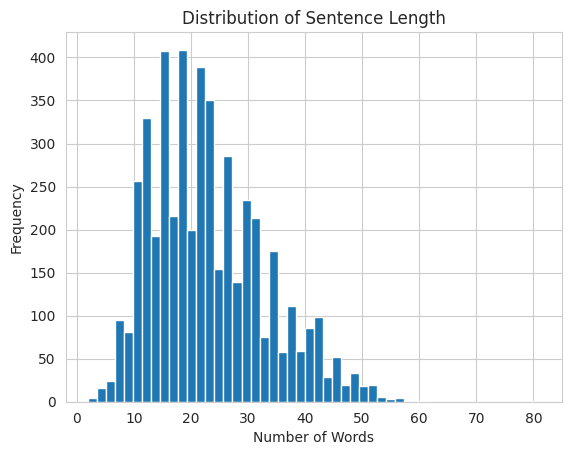

Max length: 81
Average length: 23.100722394220846


In [ ]:
df.rename(columns={'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .': 'sentence'}, inplace=True)
df['text_length'] = df['sentence'].apply(lambda x: len(str(x).split()))

plt.figure()
plt.hist(df['text_length'], bins=50)
plt.title("Distribution of Sentence Length")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

print("Max length:", df['text_length'].max())
print("Average length:", df['text_length'].mean())

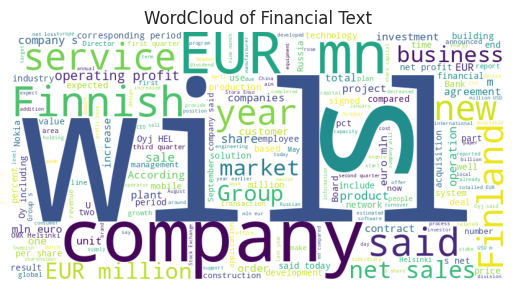

In [ ]:
from wordcloud import WordCloud

text = " ".join(df['sentence'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title("WordCloud of Financial Text")
plt.show()

**CNN for Text (KimCNN variant)**

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
df = pd.read_csv("all-data.csv", encoding='latin1')
df.rename(columns={'neutral': 'label', 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .': 'sentence'}, inplace=True)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (4845, 2)


,label,sentence
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


### Preprocessing Text Data

Before feeding the text data into the model, it's essential to clean it. This involves converting text to lowercase, removing special characters, and extra spaces. I will define a `clean_text` function and apply it to the `sentence` column.

In [ ]:
import re

def clean_text(text):
    text = str(text).lower()  # Ensure text is string and convert to lowercase
    text = re.sub(r"[^a-z0-9\s]", " ", text) # Remove special characters
    text = re.sub(r"\s+", " ", text) # Remove extra spaces
    text = text.strip()
    return text

df["sentence"] = df["sentence"].apply(clean_text)
print("First 5 cleaned sentences:")
print(df["sentence"].head())

First 5 cleaned sentences:
0    technopolis plans to develop in stages an area...
1    the international electronic industry company ...
2    with the new production plant the company woul...
3    according to the company s updated strategy fo...
4    financing of aspocomp s growth aspocomp is agg...
Name: sentence, dtype: object


Now that the `sentence` column has been cleaned, you should re-run all subsequent cells to ensure the updated data is used for splitting, vocabulary building, and model training.

In [ ]:
label_map = {label: idx for idx, label in enumerate(df["label"].unique())}
df["label_id"] = df["label"].map(label_map)

X_train, X_temp, y_train, y_temp = train_test_split(
    df["sentence"],
    df["label_id"],
    test_size=0.3,
    stratify=df["label_id"],
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=2/3,
    stratify=y_temp,
    random_state=42
)

print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))

Train: 3391
Val: 484
Test: 970


In [ ]:
print(df["label"].value_counts())
print("\nClass ratio:")
print(df["label"].value_counts(normalize=True))

label
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64

Class ratio:
label
neutral     0.594014
positive    0.281321
negative    0.124665
Name: proportion, dtype: float64


In [ ]:
df["length"] = df["sentence"].apply(lambda x: len(x.split()))

print("Mean length:", df["length"].mean())
print("Median length:", df["length"].median())
print("Max length:", df["length"].max())

Mean length: 23.100722394220846
Median length: 21.0
Max length: 81


In [ ]:
def tokenize(text):
    return text.lower().split()

counter = Counter()
for text in X_train:
    counter.update(tokenize(text))

vocab = {"<PAD>":0, "<UNK>":1}
for word in counter:
    vocab[word] = len(vocab)

print("Vocabulary size:", len(vocab))

Vocabulary size: 9534


In [ ]:
def compute_oov(texts):
    total = 0
    oov = 0
    for text in texts:
        for word in tokenize(text):
            total += 1
            if word not in vocab:
                oov += 1
    return oov / total

print("OOV rate (Val):", compute_oov(X_val))

OOV rate (Val): 0.07335529244191222


In [ ]:
MAX_LEN = int(df["length"].mean()) + 10
print("MAX_LEN:", MAX_LEN)

def encode(text):
    tokens = tokenize(text)
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens]
    if len(ids) < MAX_LEN:
        ids += [0]*(MAX_LEN-len(ids))
    else:
        ids = ids[:MAX_LEN]
    return ids

MAX_LEN: 33


In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(encode(self.texts[idx])), torch.tensor(self.labels[idx])

train_ds = TextDataset(X_train, y_train)
val_ds   = TextDataset(X_val, y_val)
test_ds  = TextDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, 100, kernel_size=3),
            nn.Conv1d(embed_dim, 100, kernel_size=4),
            nn.Conv1d(embed_dim, 100, kernel_size=5)
        ])

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(300, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)

        conv_outs = [torch.relu(conv(x)) for conv in self.convs]
        pooled = [torch.max(out, dim=2)[0] for out in conv_outs]

        x = torch.cat(pooled, dim=1)
        x = self.dropout(x)
        return self.fc(x)

In [ ]:
model = TextCNN(len(vocab), 100, len(label_map)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 25
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

train_time = time.time() - start_time
print("Training time (seconds):", train_time)

Epoch 1, Loss: 0.9344
Epoch 2, Loss: 0.7097
Epoch 3, Loss: 0.5688
Epoch 4, Loss: 0.4597
Epoch 5, Loss: 0.3556
Epoch 6, Loss: 0.2869
Epoch 7, Loss: 0.2197
Epoch 8, Loss: 0.1727
Epoch 9, Loss: 0.1449
Epoch 10, Loss: 0.1047
Epoch 11, Loss: 0.0937
Epoch 12, Loss: 0.0771
Epoch 13, Loss: 0.0756
Epoch 14, Loss: 0.0579
Epoch 15, Loss: 0.0458
Epoch 16, Loss: 0.0348
Epoch 17, Loss: 0.0494
Epoch 18, Loss: 0.0272
Epoch 19, Loss: 0.0278
Epoch 20, Loss: 0.0287
Epoch 21, Loss: 0.0287
Epoch 22, Loss: 0.0258
Epoch 23, Loss: 0.0249
Epoch 24, Loss: 0.0331
Epoch 25, Loss: 0.0165
Training time (seconds): 103.3040382862091


In [ ]:
def evaluate(loader):
    model.eval()
    preds, true = [], []

    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            outputs = model(texts)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()

            preds.extend(predictions)
            true.extend(labels.numpy())

    acc = accuracy_score(true, preds)
    macro = f1_score(true, preds, average="macro")
    weighted = f1_score(true, preds, average="weighted")

    return acc, macro, weighted, true, preds

acc, macro, weighted, y_true, y_pred = evaluate(test_loader)

print("Accuracy:", acc)
print("Macro-F1:", macro)
print("Weighted-F1:", weighted)

Accuracy: 0.7268041237113402
Macro-F1: 0.6636537929303447
Weighted-F1: 0.7218323429539675


In [ ]:
print("\nPer-class metrics:")
print(classification_report(y_true, y_pred, target_names=label_map.keys()))


Per-class metrics:
              precision    recall  f1-score   support

     neutral       0.78      0.84      0.81       576
    negative       0.62      0.55      0.58       121
    positive       0.64      0.57      0.60       273

    accuracy                           0.73       970
   macro avg       0.68      0.65      0.66       970
weighted avg       0.72      0.73      0.72       970



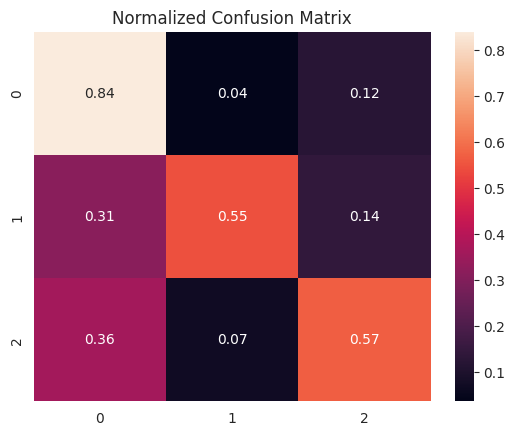

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure()
sns.heatmap(cm, annot=True, fmt=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()

In [ ]:
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024**2)
print("Model size (MB):", model_size)

Model size (MB): 4.099285125732422
